# Question 4: Implementing the image denoising problem

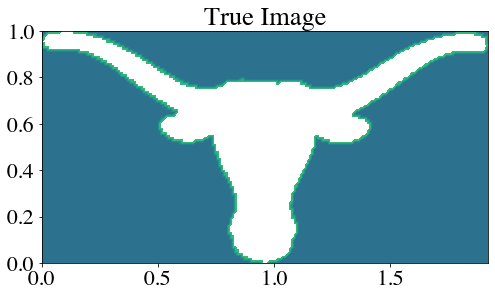

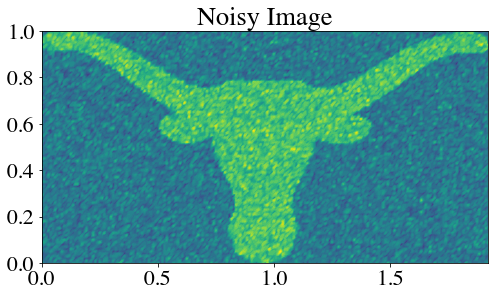

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from dolfin import *
import math
import numpy as np
import logging
from unconstrainedMinimization import InexactNewtonCG
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family': 'Times'})

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)


# Set the level of noise:
noise_std_dev = .3

# Load the image from file
data = np.loadtxt('image.dat', delimiter=',')
np.random.seed(seed=1)

noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])
Lx = float(data.shape[1])/float(data.shape[0])
Ly = 1.

mesh = RectangleMesh(Point(0,0),Point(Lx,Ly), 200, 100)
V = FunctionSpace(mesh, "Lagrange",1)

# Generate the true image (u_true) and the noisy data (u_0)
class Image(UserExpression):
    def __init__(self, Lx, Ly, data, **kwargs):
        super().__init__(kwargs)
        self.data = data
        self.hx = Lx/float(data.shape[1]-1)
        self.hy = Ly/float(data.shape[0]-1)
        
    def eval(self, values, x):
        j = int(math.floor(x[0]/self.hx))
        i = int(math.floor(x[1]/self.hy))
        values[0] = self.data[i,j]
        
    def value_shape(self):
        return ()

trueImage  = Image(Lx, Ly, data, element=V.ufl_element())
noisyImage = Image(Lx, Ly, data+noise, element=V.ufl_element())

u_true  = interpolate(trueImage, V)
u_0     = interpolate(noisyImage, V)

vmin = np.min(u_0.vector().get_local())
vmax = np.max(u_0.vector().get_local())

plt.figure(figsize=[8,8])
plot(u_true, title="True Image", vmin=vmin, vmax = vmax)
plt.savefig("Q4_true.pdf")
plt.figure(figsize=[8,8])
plot(u_0, title="Noisy Image", vmin=vmin, vmax = vmax)
plt.savefig("Q4_Noisy.pdf")
plt.show()

# Part (a): Solving using Tikhonov (TN) regularization

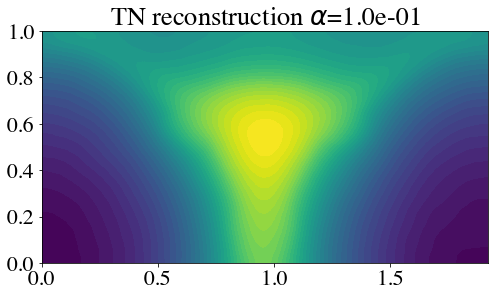

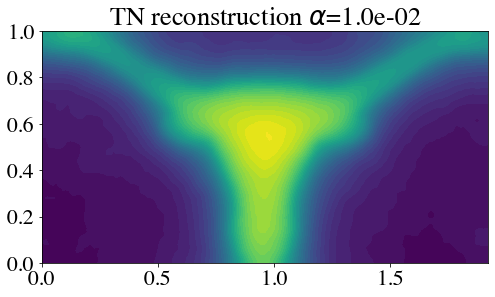

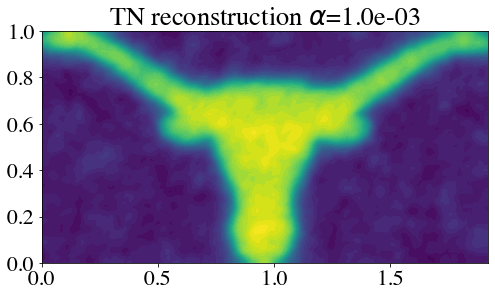

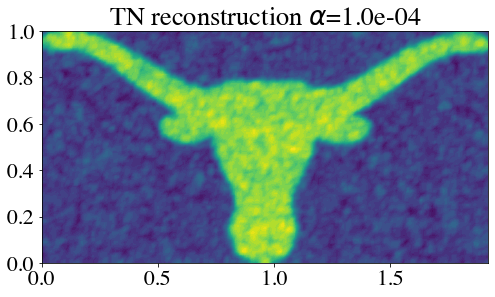

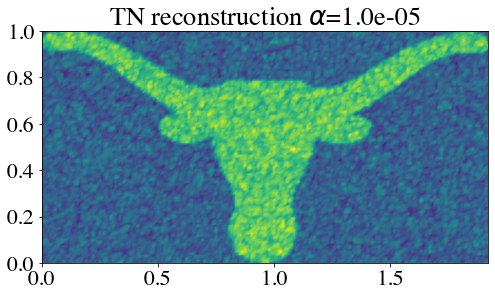

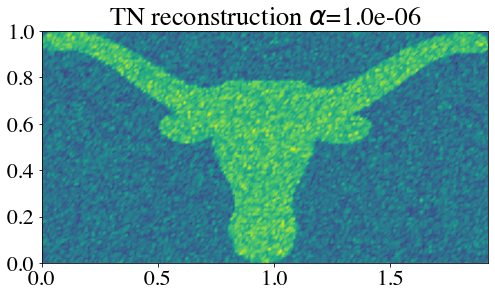

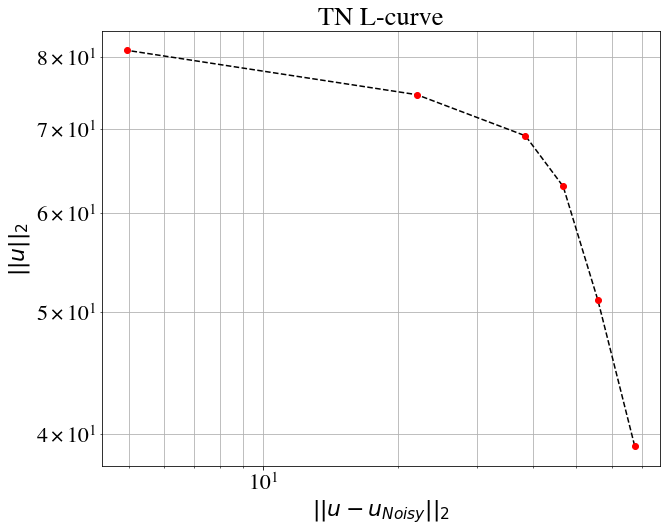

In [7]:
# Denoising using TN regularization using linear solve

# Defining functional forms
def TN_functions(alpha_val):
    """ linear form - solve lhs == rhs """
    alpha = Constant(alpha_val)
    u_trial = TrialFunction(V)
    u_test = TestFunction(V)
    J_tn = (u_trial - u_0)*u_test*dx + alpha*inner(grad(u_trial), grad(u_test))*dx
    return lhs(J_tn), rhs(J_tn)

# TN regularization
alphas = np.logspace(-1,-6,6)
r_tn_norm = []
u_tn_norm = []
u_tn_list = []

for alpha in alphas:
    u_tn = Function(V)
    # linear solve
    a_tn, L_tn = TN_functions(alpha)
    solve(a_tn==L_tn, u_tn)

    # Misfit
    r_tn_norm.append(np.linalg.norm(u_tn.vector()[:] - u_0.vector()[:]))
    u_tn_norm.append(np.linalg.norm(u_tn.vector()[:]))
    u_tn_list.append(u_tn.copy())
    plt.figure(figsize=(8,8))
    plot(u_tn, title="TN reconstruction $\\alpha$=%.1e" %(alpha))
    # plot(u_tn, title="TN reconstruction k=%.1e" %(alpha), vmin=vmin, vmax=vmax
    , cmap=cmap)
    plt.savefig("q3_tn_%.1e_.png" %(alpha))

# plot l-curve
plt.figure(figsize=(10,8))
plt.loglog(r_tn_norm, u_tn_norm,'k--')
plt.loglog(r_tn_norm, u_tn_norm,'ro')
plt.grid(True, which="both")
plt.xlabel(r'$||u - u_{Noisy}||_2$')
plt.ylabel(r'$||u||_2$')
plt.title("TN L-curve")
plt.savefig("q3_lcurve_TN.png")

 

# Part (b): Solving using Total variation regularization

In [3]:
# Define solver
solver = InexactNewtonCG()
solver.parameters["rel_tolerance"] = 1e-6
solver.parameters["abs_tolerance"] = 1e-9
solver.parameters["gdu_tolerance"] = 1e-18
solver.parameters["max_iter"] = 5000
solver.parameters["c_armijo"] = 1e-5
solver.parameters["print_level"] = 1
solver.parameters["max_backtracking_iter"] = 10